In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
import statsmodels.api as sm
warnings.filterwarnings('ignore')
np.random.seed(42)
from scipy.stats import norm

In [186]:
import zipfile
with zipfile.ZipFile("archive.zip","r") as zip_ref:
    zip_ref.extractall()

## Introduction
Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. We're not kidding!
<br><br>
<center><img src="https://i.pinimg.com/originals/eb/3c/4b/eb3c4b5be29530a68c32434297d6f8b5.png" width=200/></center>



As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention.
<br><br>
This sort of “time gate” is usually seen in free-to-play models, and normally contains ads that can be skipped using credits. In this case the player requires to submit a specific number of ‘Keys’, which also can be skipped in exchange of in-game purchases.

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|userid| A unique number that identifies each player.|Category values|
|version| Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).|category|
|sum_gamerounds|The number of game rounds played by the player during the first 14 days after install.`|int64|
|retention_1|Did the player come back and play 1 day after installing?|Boolean|
|retention_7|Did the player come back and play 7 days after installing?|Boolean|
</center>

In [54]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [59]:
df.nunique()

userid            90189
version               2
sum_gamerounds      942
retention_1           2
retention_7           2
dtype: int64

In [56]:
print('The number of duplicated rows are: ',df.duplicated().sum())

The number of duplicated rows are:  0


## Data Exploration of the feature sum_gamerounds:

In [62]:
print('We can see that 50% of our players have not played more than 16 rounds and 75% of our players have not played more than        51 rounds. There is clearly a really high end outlier present here.')
df.sum_gamerounds.describe().to_frame()

We can see that 50% of our players have not played more than 16 rounds and 75% of our players have not played more than        51 rounds. There is clearly a really high end outlier present here.


,sum_gamerounds
count,90189.000000
mean,51.872457
std,195.050858
min,0.000000
25%,5.000000
50%,16.000000
75%,51.000000
max,49854.000000


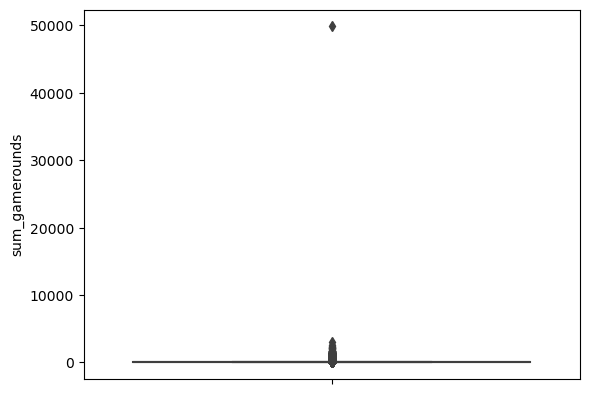

In [52]:
sb.boxplot(data=df,y='sum_gamerounds');

-  50% of the Players are quiting the game after reaching the 16th round and  75 % of the Players are quitting the game after reaching the 51st round. The reasons for quitting the game could be:- 
Levels after this round are really tough to crack, the players are getting bored after this round, the players are not finding the interface exciting anymore.
- The company should send a feedback form/survey to each customer/player and analyze the root cause of this problem.

### Q) Should the first gate in Cookie Cats be moved from level 30 to level 40?
**The answer is divided into 2 parts:**
1) Probability, AB Testing, Z-Score Hypothesis Testing for Day 1 Retention.<br>
2) Probability, AB Testing, Z-Score Hypothesis Testing for Day 7 Retention.

### <u>Day 1 Retention (Probability)</u>

In [8]:
print('a. Number of unique players in control group: {} \n   Number of unique players in experiment group: {}'.format(df.query('version == "gate_30"').userid.nunique(),df.query('version == "gate_40"').userid.nunique()))

a. Number of unique players in control group: 44700 
   Number of unique players in experiment group: 45489


**b.** "Day 1 Retention rate" of players in the group control (gate_30 version):

In [9]:
p_old = df[(df['version'] == "gate_30")]['retention_1'].mean()
p_old

0.4481879194630872

**c.** "Day 1 Retention rate" of players in the group experiment (gate_40 version):

In [10]:
p_new = df[(df['version'] == "gate_40")]['retention_1'].mean()
p_new

0.44228274967574577

**d.**  The actual difference (obs_diff) between the "Day 1 Retention rates" for the two groups.

In [11]:
obs_diff = p_new - p_old
obs_diff

-0.005905169787341458

#### Observed Difference in the proportion tells us that :
The "Day 1 retention rate" for the players when they encounter the gate level 30 is <b>0.0059%</b> greater than The "Day 1 retention rate" of players when they encounter the gate level 40.

***Let's find out if this conclusion is Statistically Significant or not!!***

### <u>Day 1  retention AB Testing</u>

 **$p_{old}$** and **$p_{new}$**,  are the "Day 1 retention rate" for the old and new versions respectively.
 
$$H_0: p_{new} - p_{old} <= 0$$
$$H_1: p_{new} - p_{old} >  0$$

**a.** $n_{new}$, the number of players who are using new version? <br><br>

In [12]:
nnew = df.query('version == "gate_40"').shape[0] # number of players who were using new version
nnew

45489

**b.** $n_{old}$, the number of players who are using old version? <br><br>

In [13]:
nold = df.query('version == "gate_30"').shape[0] # number of players who were  using old version
nold

44700

**c. Simulating Sample for the `group_30`** <br>
Simulating $n_{old}$ number of players with a retention1 rate of $p_{old}$ under the null hypothesis. <br> Storing these $n_{old}$ 1's and 0's in the `retention1_old` numpy array

In [14]:
retention1_old = np.random.choice([1,0],nold,p=[p_old,1-p_old])
retention1_old.mean()

0.4463087248322148

**d. Simulating Sample for the `group_40`** <br>
Simulating $n_{new}$ number of players with a retention1 rate of $p_{new}$ under the null hypothesis. <br> Storing these $n_{new}$ 1's and 0's in the `retention1_new` numpy array

In [15]:
retention1_new = np.random.choice([1,0],nnew,p=[p_new,1-p_new])
retention1_new.mean()

0.44375563323001166

**e.** Find the difference in the probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (c) and (d) above. 

In [16]:
retention1_new.mean() - retention1_old.mean()

-0.002553091602203128

**f. Sampling distribution** <br>
Re-creating `retention1_old` and `retention1_new` and finding the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times.

<br>
Storing all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [216]:
p_diffs = []
for _ in range(10000):
    retention1_old = np.random.choice([1,0],nold,p=[p_old,1 - p_old])
    retention1_new = np.random.choice([1,0],nnew,p=[p_new,1- p_new])
    obs_diff =  retention1_new.mean() - retention1_old.mean() 
    p_diffs.append(obs_diff)

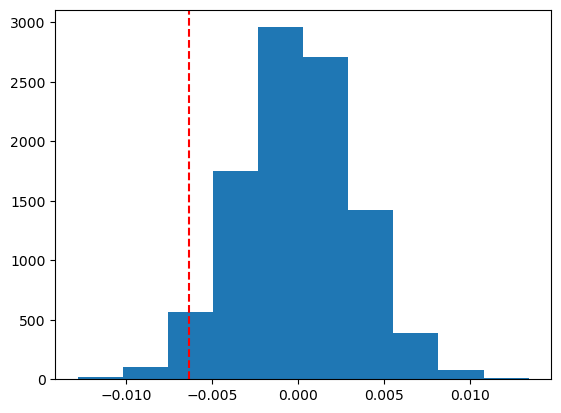

In [217]:
p_diffs = np.array(p_diffs)
p_diffs = np.random.normal(0,p_diffs.std(),p_diffs.size)
plt.hist(p_diffs)
plt.axvline(x= obs_diff,c="r",linestyle = '--');

In [218]:
(p_diffs > obs_diff).mean()

0.9727

- Our <b>p value is greater than Type-I error (0.05)</b> which means that <b>we fail to reject our Null Hypothesis.</b>
- We have statistical evidence to proof that the difference between Day-1-Retention-Rate of players when they encounter the gate level 30 and Day-1-Retention-Rate of players when they encounter the gate level 40 is less than 0.

### <u>Z-Score Hypothesis Testing for Day 1 Retention using Built-in functions</u>

In [219]:
nold = df.query('version == "gate_30" and retention_1 == True').shape[0]
nnew = df.query('version == "gate_40" and retention_1 == True').shape[0]

n_30 = len(df.query('version == "gate_30"'))
n_40 = len(df.query('version == "gate_40"'))

count = [nnew,nold]
nobs = [n_40,n_30]

z_score,p_value = sm.stats.proportions_ztest(count,nobs,alternative='larger')
z_score,p_value

(-1.7840862247974725, 0.9627951723515404)

In [220]:
z_critical = norm.ppf(1-(0.05))
z_critical

1.6448536269514722

<b>Our Z score < Critical Score and p value is greater than Type-I error(0.05)</b>. **Hence, we fail to reject our Null Hypothesis.**

### <u>Day 7 Retention Probability</u>

**a.** "Day 7 Retention rate" of players in the group control (gate_30 version):

In [221]:
p_old = df.query('version == "gate_30"')['retention_7'].mean()
p_old

0.19020134228187918

**b.** "Day 7 Retention rate" of players in the group experiment (gate_40 version):

In [222]:
p_new = df.query('version == "gate_40"')['retention_7'].mean()
p_new

0.18200004396667327

**c.**  The actual difference (obs_diff) between the "Day 7 Retention rates" for the two groups.

In [223]:
obs_diff = p_new - p_old
obs_diff

-0.008201298315205913

#### Observed Difference in the proportion tells us that :
The "Day 7 retention rate" for the players when they encounter the gate level 30 is <b>0.0082%</b> greater than The "Day 7 retention rate" of players when they encounter the gate level 40 .

***Let's find out if this conclusion is Statistically Significant or not!!***

### <u>Day 7  retention AB Testing</u>

 **$p_{old}$** and **$p_{new}$**,  are the "Day 7 retention rate" for the old and new versions respectively.
 
$$H_0: p_{new} - p_{old} <= 0$$
$$H_1: p_{new} - p_{old} >  0$$

**a.** $n_{new}$, the number of players who are using new version? <br><br>

In [224]:
nnew = df.query('version == "gate_40"').shape[0] # number of players who were using new version
nnew

45489

**b.** $n_{old}$, the number of players who are using old version? <br><br>

In [225]:
nold = df.query('version == "gate_30"').shape[0] # number of players who were  using old version
nold

44700

**c. Simulating Sample for the `group_30`** <br>
Simulating $n_{old}$ number of players with a retention7 rate of $p_{old}$ under the null hypothesis. <br> Storing these $n_{old}$ 1's and 0's in the `retention7_old` numpy array

In [226]:
retention7_old = np.random.choice([1,0],nold,p=[p_old,1-p_old])
retention7_old.mean()

0.18937360178970916

**d. Simulating Sample for the `group_40`** <br>
Simulating $n_{new}$ number of players with a retention7 rate of $p_{new}$ under the null hypothesis. <br> Storing these $n_{new}$ 1's and 0's in the `retention7_new` numpy array

In [227]:
retention7_new= np.random.choice([1,0],nnew,p=[p_new,1-p_new])
retention7_new.mean()

0.17874651014530984

**e.** Find the difference in the probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (c) and (d) above.

In [228]:
retention7_new.mean() - retention7_old.mean()

-0.010627091644399317

**f. Sampling distribution** <br>
Re-creating `retention7_old` and `retention7_new` and finding the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times.

<br>
Storing all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [229]:
p_diffs = []
for _ in range(10000):
    retention1_old = np.random.choice([1,0],nold,p=[p_old,1 - p_old])
    retention1_new = np.random.choice([1,0],nnew,p=[p_new,1- p_new])
    obs_diff = retention1_new.mean() - retention1_old.mean() 
    p_diffs.append(obs_diff)

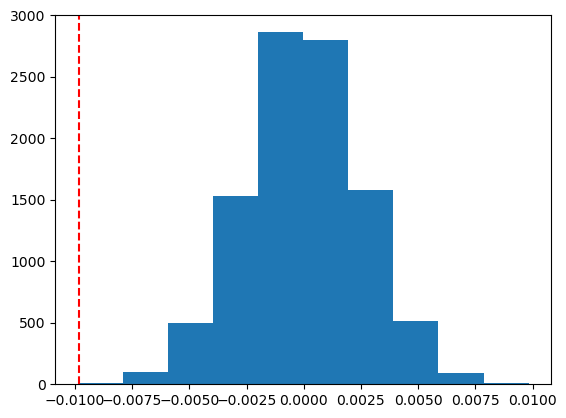

In [230]:
p_diffs = np.array(p_diffs)
p_diffs = np.random.normal(0,p_diffs.std(),p_diffs.size)
plt.hist(p_diffs)
plt.axvline(x= obs_diff,c="r",linestyle = '--');

In [231]:
(p_diffs > obs_diff).mean()

0.9999

- Our p value is greater than Type-I error (0.05) which means that <b>we fail to reject our Null Hypothesis.</b>
- We have statistical evidence to proof that the difference between Day-7-Retention-Rate of players when they encounter the gate level 30 and Day-7-Retention-Rate of players when they encounter the gate level 40 is less than 0.

In [233]:
n_30 = len(df.query('version == "gate_30"'))
n_40 = len(df.query('version == "gate_40"'))

nold = df.query('version == "gate_30" and retention_7 == True').shape[0]
nnew = df.query('version == "gate_40" and retention_7 == True').shape[0]

count = [nnew,nold]
nobs = [n_40,n_30]

z_score,p_value = sm.stats.proportions_ztest(count,nobs)
z_score,p_value

(-3.164358912748191, 0.001554249975614329)

<b>Our Z score < Critical Score and p value is greater than Type-I error(0.05)</b>. **Hence, we fail to reject our Null Hypothesis.**

## Conclusion
-  50% of the Players are quiting the game after reaching the 16th round and  75 % of the Players are quitting the game after reaching the 51th round. The reasons for quitting the game could be:- 
    - Levels after this round are really tough to crack
    - The players are getting bored after this level
    - and many more.
- The company should send a feedback form/survey to each customer/player and analyze the root cause of this problem.
- We have strong statistical evidence to proof that, the day 1 and day 7 Retention Rate of players when they encounter the gate_30 level is higher than when they are gate_40 level.

    - The "Day 1 retention rate" for the players when they encounter the gate level 30 is <b>0.0059%</b> greater than The "Day 1 retention rate" of players when they encounter the gate level 40.
    - The "Day 7 retention rate" for the players when they encounter the gate level 30 is <b>0.0082%</b> greater than The "Day 7 retention rate" of players when they encounter the gate level 40 .
- **<u>It is recommended that the company does not move the first gate in Cookie Cats from level 30 to level 40.**